In [31]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math

#Чтение исходных данных
df_metro = pd.read_csv('data/metro.csv', encoding='UTF-8', sep=';')
df_trans = pd.read_csv('data/transitions.csv', encoding='UTF-8', sep=';')

df_trains = pd.read_csv('data/stations.csv', encoding='UTF-8', sep=';')

df_stats = pd.concat([df_metro, df_trains], ignore_index=True)

#Нумерация станций
df_stats.insert(0, "row_number", df_stats.index + 1)
df_stats.insert(1, "graph_number", df_stats.index + 1)
df_stats.tail()

,row_number,graph_number,line,number,station,line_shape
1089,1090,1090,Ярославское:2:2,13,90 км,line
1090,1091,1091,Ярославское:2:2,14,Арсаки,line
1091,1092,1092,Ярославское:2:2,15,Струнино,line
1092,1093,1093,Ярославское:2:2,16,Александров-1,line
1093,1094,1094,Ярославское:2:2,17,Балакирево,line


In [32]:
df_trans_row = df_trans.merge(df_stats, how='inner', left_on=["src_line","src_number"], right_on=["line","number"]).merge(df_stats, how='inner', left_on=["dest_line","dest_number"], right_on=["line","number"])[['type','line_x','row_number_x','line_y','row_number_y']]

transitions_list = df_trans_row[["row_number_x","row_number_y"]].values.tolist()
#stations_list = df_stats["graph_number"].values.tolist()

#Совмещение станций
for trans in transitions_list:
    src_stat = df_stats.loc[(df_stats.row_number == trans[0]),"graph_number"].values[0]
    df_stats.loc[(df_stats.row_number == trans[1]),"graph_number"] = src_stat

In [33]:
def build_graph(stations, transitions):
    graph = nx.Graph()
    graph.add_nodes_from(stations)
    graph.add_edges_from(transitions)
    return graph


def build_network_l(df_stations, df_transitions):  
    stations_list = df_stations["graph_number"].values.tolist()
    circle_line_list = pd.unique(df_stations.loc[df_stations.line_shape == 'circle']["line"].values)

    connections_list = []
    for i in df_stations["row_number"].values.tolist()[:-1]:
        if df_stations.loc[df_stations["row_number"] == i]["line"].values[0] == df_stations.loc[df_stations["row_number"] == i + 1]["line"].values[0]:
            connections_list.append([stations_list[i - 1], stations_list[i]])

    for line in circle_line_list:
        connections_list.append([df_stations.loc[df_stations['line'] == line]["graph_number"].values[0], df_stations.loc[df_stations['line'] == line]["graph_number"].values[-1]])

    stations_list = pd.unique(stations_list)
    
    return build_graph(stations_list, connections_list)


def build_network_p(df_stations, df_transitions):
    stations_list = df_stations["graph_number"].values.tolist()

    line_type_list = []
    line_list = list(pd.unique(df_stations["line"].values))
    for line in line_list:
        if ':' in line:
            subline = line[:line.rfind(':')]
            line_type_list[line_list.index(subline)][1] = 'side'
        line_type_list.append([line, 'main'])

    lines = []
    for line in line_type_list:
        if line[1] == 'main':
            lines.append(line[0])

    connections_list = []
    for line in lines:
        line_list = [line] #список совместных направлений
        while ':' in line:
            line = line[:line.rfind(':')]
            line_list.append(line)

        line_stations = df_stations.loc[df_stations['line'].isin(line_list)]["row_number"].values.tolist()
        for i in line_stations[:-1]:
            for j in line_stations[line_stations.index(i):]:
                if i != j:                
                    connections_list.append([stations_list[i - 1], stations_list[j - 1]])

    stations_list = pd.unique(stations_list)

    return build_graph(stations_list, connections_list)


def build_network_c(df_stations, df_transitions):
    line_list, subline_list = [], []
    for line in pd.unique(df_stations["line"].values):
        subline = line
        while ':' in subline:
            subline = subline[:subline.rfind(':')]

        line_list.append(line)
        subline_list.append(subline)

    transitions_list = df_transitions.loc[df_transitions['type'] != 'trains'][['line_x','line_y']].drop_duplicates().values.tolist()

    for i in range(len(transitions_list)):
        if transitions_list[i][0] in line_list:
            transitions_list[i][0] = subline_list[line_list.index(transitions_list[i][0])]
        if transitions_list[i][1] in line_list:
            transitions_list[i][1] = subline_list[line_list.index(transitions_list[i][1])]

    subline_list = list(set(subline_list))
    subline_list.remove('Кольцевое')
    
    return build_graph(subline_list, transitions_list)

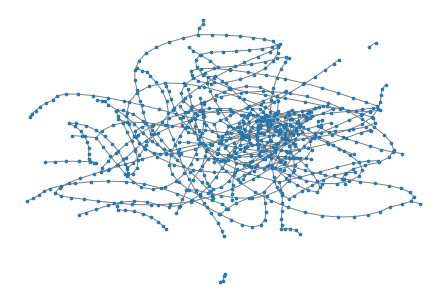

In [34]:
l_network = build_network_l(df_stats, df_trans_row)
nx.draw(l_network, width=1, node_size=7, edge_color='gray')
plt.show()

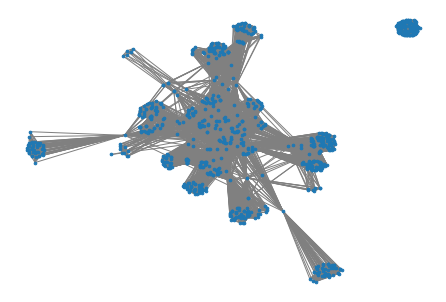

In [35]:
p_network = build_network_p(df_stats, df_trans_row)
nx.draw(p_network, width=1, node_size=7, edge_color='gray')
plt.show()

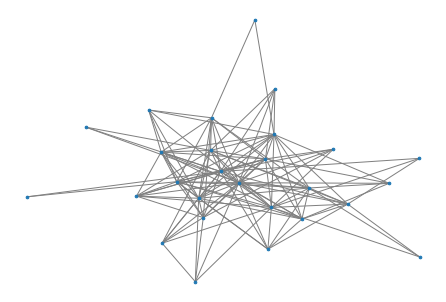

In [36]:
c_network = build_network_c(df_stats, df_trans_row)
nx.draw(c_network, width=1, node_size=7, edge_color='gray')
plt.show()

In [37]:
#Число узлов
def nodes_number(graph):
    return nx.number_of_nodes(graph)

#Число связей
def edges_number(graph):
    return nx.number_of_edges(graph)

#Средняя кластеризация
def clustering(graph):
    return nx.average_clustering(graph)

#Средняя кратчайшая длина пути
def closeness(graph):
    closeness_list = [1 / i for i in list(nx.closeness_centrality(graph).values())]
    return sum(closeness_list) / nx.number_of_nodes(graph)

#Ассортативность
def assortativity(graph):
    return nx.degree_pearson_correlation_coefficient(graph)

In [38]:
df_out = pd.DataFrame([['l_network', nodes_number(l_network), edges_number(l_network), clustering(l_network), closeness(l_network), assortativity(l_network)], 
                       ['p_network', nodes_number(p_network), edges_number(p_network), clustering(p_network), closeness(p_network), assortativity(p_network)], 
                       ['c_network', nodes_number(c_network), edges_number(c_network), clustering(c_network), closeness(c_network), assortativity(c_network)]],
                    columns=['Сеть', 'Число узлов', 'Число связей', 'Средняя кластеризация', 'Cредняя кратчайшая длина пути', 'Ассортативность'])

df_out.to_excel('./results.xlsx')
df_out

,Сеть,Число узлов,Число связей,Средняя кластеризация,Cредняя кратчайшая длина пути,Ассортативность
0,l_network,879,956,0.008592,93.769549,0.389050
1,p_network,879,25328,0.914571,3.565689,0.569551
2,c_network,27,132,0.677475,1.678063,-0.346813


In [39]:
df_l_stat = pd.DataFrame(columns=['Линия','Станция', 'Степень'])
for node, degree in nx.degree(l_network):
    pd_row = pd.DataFrame([[df_stats.loc[df_stats['row_number'] == node]['line'].values[0]
                            , df_stats.loc[df_stats['row_number'] == node]['station'].values[0]
                            , degree]],
                    columns=['Линия','Станция', 'Степень'])
    df_l_stat = df_l_stat.append(pd_row)
df_l_stat = df_l_stat.sort_values('Степень', ascending=False, ignore_index=True)
print(df_l_stat[:15])
print()

bc = nx.betweenness_centrality(l_network)
df_l_betweenness_centrality = pd.DataFrame(columns=['Линия','Станция', 'Нагрузка'])
for node in bc:
    pd_row = pd.DataFrame([[df_stats.loc[df_stats['row_number'] == node]['line'].values[0]
                            , df_stats.loc[df_stats['row_number'] == node]['station'].values[0]
                            , bc[node]]],
                    columns=['Линия','Станция', 'Нагрузка'])
    df_l_betweenness_centrality = df_l_betweenness_centrality.append(pd_row)
df_l_betweenness_centrality = df_l_betweenness_centrality.sort_values('Нагрузка', ascending=False, ignore_index=True)
print(df_l_betweenness_centrality[:15])  
print()

cc = nx.closeness_centrality(l_network)
df_l_closeness_centrality = pd.DataFrame(columns=['Линия','Станция', 'Близость'])
for node in cc:
    pd_row = pd.DataFrame([[df_stats.loc[df_stats['row_number'] == node]['line'].values[0]
                            , df_stats.loc[df_stats['row_number'] == node]['station'].values[0]
                            , cc[node]]],
                    columns=['Линия','Станция', 'Близость'])
    df_l_closeness_centrality = df_l_closeness_centrality.append(pd_row)
df_l_closeness_centrality = df_l_closeness_centrality.sort_values('Близость', ascending=False, ignore_index=True)
print(df_l_closeness_centrality[:15])  
print()

                         Линия                  Станция Степень
0          Арбатско-Покровская                 Киевская       8
1               Сокольническая            Комсомольская       8
2               Замоскворецкая               Войковская       8
3               Сокольническая  Библиотека имени Ленина       7
4    Серпуховско-Тимирязевская    Петровско-Разумовская       6
5                    Кольцевая                Таганская       6
6               Замоскворецкая              Белорусская       6
7               Замоскворецкая                 Тверская       6
8                  Калининская             Авиамоторная       6
9                  Калининская           Площадь Ильича       6
10  Таганско-Краснопресненская         Октябрьское Поле       6
11          Некрасовская линия            Нижегородская       6
12         Арбатско-Покровская               Кунцевская       6
13       Люблинско-Дмитровская                 Окружная       6
14   Серпуховско-Тимирязевская          

In [40]:
df_p_stat = pd.DataFrame(columns=['Линия','Станция', 'Степень'])
for node, degree in nx.degree(p_network):
    pd_row = pd.DataFrame([[df_stats.loc[df_stats['row_number'] == node]['line'].values[0]
                            , df_stats.loc[df_stats['row_number'] == node]['station'].values[0]
                            , degree]],
                    columns=['Линия','Станция', 'Степень'])
    df_p_stat = df_p_stat.append(pd_row)
df_p_stat = df_p_stat.sort_values('Степень', ascending=False, ignore_index=True)
print(df_p_stat[:15])
print()
    
bc = nx.betweenness_centrality(p_network)
df_p_betweenness_centrality = pd.DataFrame(columns=['Линия','Станция', 'Нагрузка'])
for node in bc:
    pd_row = pd.DataFrame([[df_stats.loc[df_stats['row_number'] == node]['line'].values[0]
                            , df_stats.loc[df_stats['row_number'] == node]['station'].values[0]
                            , bc[node]]],
                    columns=['Линия','Станция', 'Нагрузка'])
    df_p_betweenness_centrality = df_p_betweenness_centrality.append(pd_row)
df_p_betweenness_centrality = df_p_betweenness_centrality.sort_values('Нагрузка', ascending=False, ignore_index=True)
print(df_p_betweenness_centrality[:15]) 
print()

cc = nx.closeness_centrality(p_network)
df_p_closeness_centrality = pd.DataFrame(columns=['Линия','Станция', 'Близость'])
for node in cc:
    pd_row = pd.DataFrame([[df_stats.loc[df_stats['row_number'] == node]['line'].values[0]
                            , df_stats.loc[df_stats['row_number'] == node]['station'].values[0]
                            , cc[node]]],
                    columns=['Линия','Станция', 'Близость'])
    df_p_closeness_centrality = df_p_closeness_centrality.append(pd_row)
df_p_closeness_centrality = df_p_closeness_centrality.sort_values('Близость', ascending=False, ignore_index=True)
print(df_p_closeness_centrality[:15])  
print()

                            Линия                 Станция Степень
0                  Сокольническая           Комсомольская     323
1      Таганско-Краснопресненская  Лермонтовский проспект     162
2             Арбатско-Покровская        Электрозаводская     162
3   Московское центральное кольцо              Андроновка     161
4             Арбатско-Покровская                 Курская     157
5      Таганско-Краснопресненская                  Выхино     154
6                     Калининская            Авиамоторная     148
7                       Казанское               Люберцы 1     135
8                       Казанское           Сортировочная     133
9                     Калининская          Площадь Ильича     133
10                      Казанское                  Перово     133
11                      Казанское                 Плющево     133
12                      Казанское                 Вешняки     133
13                      Казанское               Ухтомская     133
14        

In [ ]:
df_l_stat.to_excel('./l_stat.xlsx')
df_l_betweenness_centrality.to_excel('./l_betweenness_centrality.xlsx')
df_l_closeness_centrality.to_excel('./l_closeness_centrality.xlsx')
df_p_stat.to_excel('./p_stat.xlsx')
df_p_betweenness_centrality.to_excel('./p_betweenness_centrality.xlsx')
df_p_closeness_centrality.to_excel('./p_closeness_centrality.xlsx')